In [1]:
import matplotlib.pyplot as plt
import re
import shutil
import seaborn as sns
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.preprocessing import label_binarize
import torchvision
from sklearn.metrics import roc_curve,auc, precision_score,precision_recall_curve,recall_score,precision_recall_fscore_support,confusion_matrix
import numpy as np
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from PytMulticlass import Model_class
gpu_id = 5
!nvidia-smi

Thu Aug  5 14:53:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   50C    P2    62W / 250W |    863MiB / 11178MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   25C    P8     6W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
transformation = transforms.Compose([transforms.Resize((110,110)),transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root = "CIFAR10/",train=True,download=True,transform=transformation)
train_data,validation_data = torch.utils.data.dataset.random_split(train_dataset,[35000,15000])
train_loader = DataLoader(train_data,shuffle=True,batch_size=64)
validate_loader = DataLoader(validation_data,shuffle=True,batch_size=64)
test_dataset = datasets.CIFAR10(root='CIFAR10/',train=False,download=True,transform=transformation)
test_loader=DataLoader(test_dataset,shuffle=True,batch_size=64)

print(len(train_data))
print(len(test_dataset))
print(len(validation_data))
# print(len(train_dataset))

print(dir(datasets))

Files already downloaded and verified
Files already downloaded and verified
35000
10000
15000
['CIFAR10', 'CIFAR100', 'Caltech101', 'Caltech256', 'CelebA', 'Cityscapes', 'CocoCaptions', 'CocoDetection', 'DatasetFolder', 'EMNIST', 'FakeData', 'FashionMNIST', 'Flickr30k', 'Flickr8k', 'HMDB51', 'ImageFolder', 'ImageNet', 'KMNIST', 'Kinetics400', 'Kitti', 'LSUN', 'LSUNClass', 'MNIST', 'Omniglot', 'PhotoTour', 'Places365', 'QMNIST', 'SBDataset', 'SBU', 'SEMEION', 'STL10', 'SVHN', 'UCF101', 'USPS', 'VOCDetection', 'VOCSegmentation', 'VisionDataset', 'WIDERFace', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_utils', 'caltech', 'celeba', 'cifar', 'cityscapes', 'coco', 'fakedata', 'flickr', 'folder', 'hmdb51', 'imagenet', 'kinetics', 'kitti', 'lsun', 'mnist', 'omniglot', 'phototour', 'places365', 'sbd', 'sbu', 'semeion', 'stl10', 'svhn', 'ucf101', 'usps', 'utils', 'video_utils', 'vision', 'voc', 'widerface']


In [3]:
class FireModule(nn.Module):
    def __init__(self,ic,mid_channel,strides=1):
        super(FireModule,self).__init__()
        self.factor = 4

        self.squeeze = nn.Conv2d(ic,mid_channel,kernel_size=1,stride=1)
        self.relu = nn.ReLU(inplace=True)

        self.expand1x1 = nn.Conv2d(mid_channel,self.factor*mid_channel,kernel_size=1,stride=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(mid_channel,self.factor*mid_channel,kernel_size=3,stride=1,padding=1)
        self.relu2 = nn.ReLU(inplace=True)

        self.Channeldw = self.factor*mid_channel*2

        self.depthwise = nn.Conv2d(self.Channeldw,self.Channeldw,kernel_size=3,stride=strides,padding=1,groups=self.Channeldw)
        self.batchNorm = nn.BatchNorm2d(self.Channeldw)
        self.relu6_1 = nn.ReLU6(inplace=True)

        self.normal_convolution = nn.Conv2d(self.Channeldw,self.Channeldw,kernel_size=3,stride=strides,padding=1)
        self.relu6 = nn.ReLU6(inplace=True)

    def forward(self,x):
        x = self.squeeze(x)
        x = self.relu(x)
        y = self.expand1x1(x)
        y = self.relu1(y)
        z = self.expand3x3(x)
        z = self.relu2(z)
        x = torch.cat((y,z),dim=1)
        x = self.depthwise(x)
        x = self.batchNorm(x)
        x = self.relu6_1(x)
        x = self.normal_convolution(x)
        x = self.relu6(x)
        return x

class SqueezeNet_DWC(nn.Module):
    def __init__(self,ic,out_classes):
        super(SqueezeNet_DWC,self).__init__()

        self.conv = nn.Conv2d(3,96,kernel_size=7,stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fire1 = FireModule(96,16)
        self.fire2 = FireModule(128,16,strides=2)
        self.fire3 = FireModule(128,32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fire4 = FireModule(256,32)
        self.fire5 = FireModule(256,48)
        self.fire6 = FireModule(384,48)
        self.fire7 = FireModule(384,64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fire8 = FireModule(512,64,strides=2)

        self.dropout = nn.Dropout(p=0.5)
        self.convLast = nn.Conv2d(512,out_classes,kernel_size=1,stride=1)
        self.relu1 = nn.ReLU(inplace=True)

        self.aap = nn.AdaptiveAvgPool2d(output_size=(1,1))

    def forward(self,x):
        x = self.conv(x)
        x = self.relu(x) 
        x = self.maxpool(x) 

        x = self.fire1(x)
        x = self.fire2(x)
        x = self.fire3(x) 

        x = self.maxpool1(x)

        x = self.fire4(x)
        x = self.fire5(x)
        x = self.fire6(x)
        x = self.fire7(x)

        x = self.maxpool2(x)

        x = self.fire8(x)

        x = self.dropout(x)
        x = self.convLast(x)
        x = self.relu1(x)

        x = self.aap(x)
        x = x.reshape(x.shape[0],x.shape[1])
        
        return x

    
squeezenet = SqueezeNet_DWC(ic=3,out_classes=10)
print(squeezenet)

SqueezeNet_DWC(
  (conv): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fire1): FireModule(
    (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (depthwise): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
    (batchNorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu6_1): ReLU6(inplace=True)
    (normal_convolution): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu6): ReLU6(inplace=True)
  )
  (fire2): FireModule(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU(inplace=

In [4]:
Losses_ = nn.CrossEntropyLoss()
lr = 3e-4
optimizer = optim.Adam(params=squeezenet.parameters(),lr=lr)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=26,gamma=0.1)
n_epochs=30

model = Model_class(squeezenet,num_classes=10,gpu_id=gpu_id)
model.print_params()
print()
model.train(train_loader,optimizer,Losses_,lr,n_epochs,validate_loader,schedular)

total_trainable_parameters are : 9621194

epoch:[1/30],memory:[0.26116466522216797/10.91650390625], lr:[0.0003]
train_accuracy:0.2253525725121472, train_loss:1.9921504280902786
val_acc:0.33902925531914896,val_loss:1.8302253611544346

epoch:[2/30],memory:[0.2606515884399414/10.91650390625], lr:[0.0003]
train_accuracy:0.3627211739746701, train_loss:1.6694263461738879
val_acc:0.4414007093044037,val_loss:1.5769125045614039

epoch:[3/30],memory:[0.2606515884399414/10.91650390625], lr:[0.0003]
train_accuracy:0.4398831288165105, train_loss:1.4445405909740512
val_acc:0.5352615249917863,val_loss:1.3604486465454102

epoch:[4/30],memory:[0.2606515884399414/10.91650390625], lr:[0.0003]
train_accuracy:0.5102343954813328, train_loss:1.2863394296583353
val_acc:0.570722517815042,val_loss:1.2752370215476827

epoch:[5/30],memory:[0.2606515884399414/10.91650390625], lr:[0.0003]
train_accuracy:0.58398488518089, train_loss:1.1269445454180786
val_acc:0.6326462765957447,val_loss:1.109803628667872

one of the

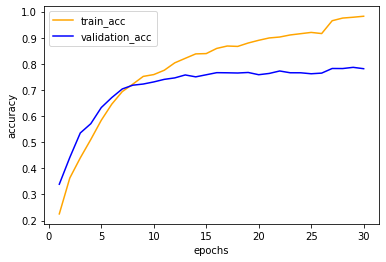

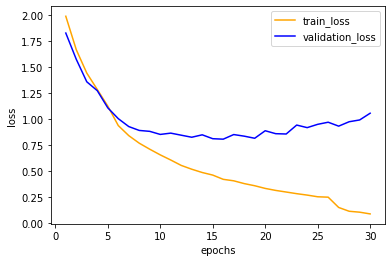

In [5]:
model.accuracy_curve()
model.loss_curve()

correct are 34071/35000
tensor(0.9735)


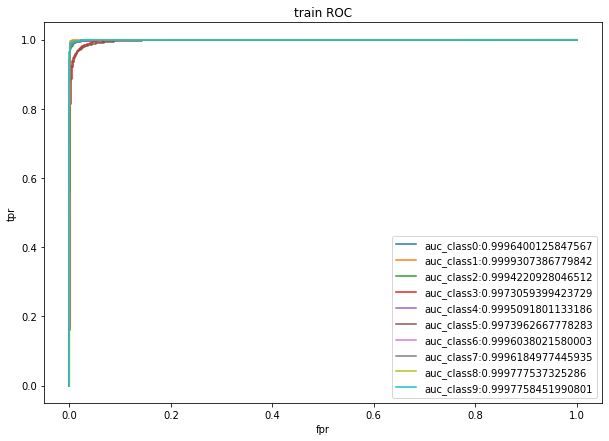

correct are 7868/10000
tensor(0.7868)


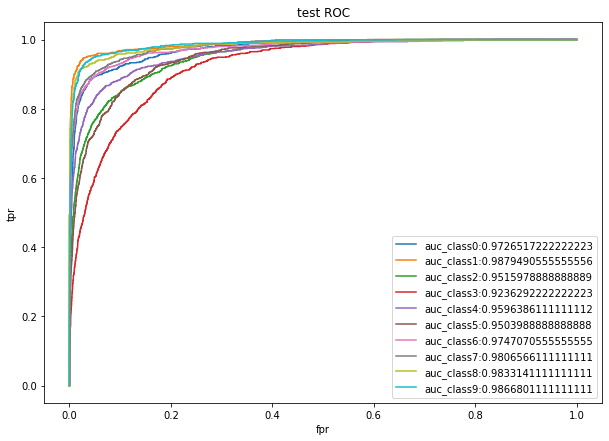

In [6]:
lab_train,pre_train,predict_train,acc_train = model.evaluate(train_loader,name='train')
print(acc_train)
model.plot_roc(fig_size=(10,7),name='train')
lab_test,pre_test,predict_test,acc_test=model.evaluate(test_loader,name='test')
print(acc_test)
model.plot_roc(fig_size=(10,7),name='test')

In [7]:
!nvidia-smi

Thu Aug  5 15:33:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   50C    P2    64W / 250W |    863MiB / 11178MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   25C    P8     6W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G